# Albert bimonthly approach
### Testing the implementation of alberts LCCS approach
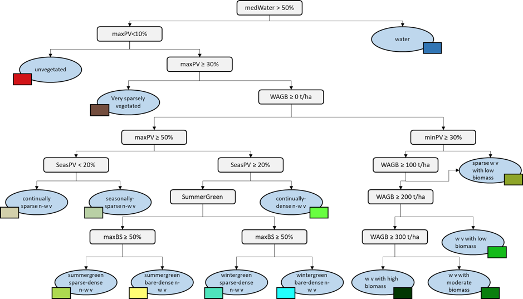


Current workflow
- For each pixel, the median of all good-quality WofS, PV, NPV, and BS estimates were calculated. 
(calculate the median for a 2 month period)
- The FC and WofS data sets were made internally consistent by allowing for the fractional cover of water (misclassified as BS in the FC product) and ensuring the total of all fractions amounts to 100%.
- Next, for each year, summary metrics were calculated from the bi-monthly median values. Specifically, for each year were calculated:
(group by min/max for annual year)


In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

dc = datacube.Datacube()

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/u46/users/bt2744/work/code/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [3]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
yaml_sites_file = os.path.abspath(str(service)+"chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "saltpan(lake gairdner)"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-25, 25)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

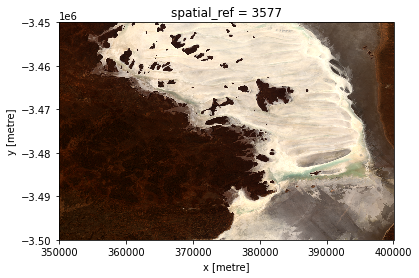

In [4]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [5]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'chris_leaust_testing/notebooks/misc/virtual_product_cat.yaml')

#### making albert products

##### first, correct all the data (FC and water)

In [6]:
# load fc wofs mask (already masked out by water flag from wofs as nan values in vp)
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

In [7]:
## basically first step is to get good data for FC observations ##
# change of name so works with consecutive count function
data = ls_fc_wofs_masked
# mask_invalid_data used here as some of the FC fractions may contain -ve values so this makes sure everything goes from 0-100%
# doesn't change anything for water dataset (as no nans in product at present)
data_nan = masking.mask_invalid_data(data)

In [8]:
# Create water and low-quality fc masks
# create dataset no water present: water (0) and no water (1) (128 clear and wet; 132 clear and wet and sea)
# invert used here otherwise would be water (1) and no water (0)
no_water = np.invert((data['water'] == 128) | (data['water'] == 132))

# where uncertainty error of pixel is high (i.e. > 30) and no water is present (1)
# this is to remove bad terrestrial data that we not picked up by the water mask of the vp
high_ue_no_water = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue_no_water))

In [9]:
# Don't need UE anymore, done its job
data_nan = data_nan.drop("UE")

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 0
data_nan['BS'] = data_nan.BS.where(no_water, 0)

# Where there's water, set water to 1
# invert no water (1) to water (could have mad a water mask before to stop inverting things, but this does the job for now)
water = np.invert(no_water)
# Where there's no water on our data_nan product set water to 0
data_nan['water'] = data_nan.water.where(water, 0)
# Where there's values for water that are 0, keep, otherwise all other values make 1
data_nan['water'] = data_nan.water.where(data_nan['water'] == 0, 1)

# now mask out nan values of water using FC
PV = data_nan.PV.isnull()
data_nan = data_nan.where(np.invert(PV))

##### second, get bimonthly medians and calculate summary metrics

In [10]:
# Resample to combine each 2 months of data into a median composite
data_bimonthly = data_nan.resample(time='2m', closed='left').median()

In [11]:
# Calculate summary bimonthly metrics
medWater = data_bimonthly.water.median(dim='time')
minPV = data_bimonthly.PV.min(dim='time')
maxPV = data_bimonthly.PV.max(dim='time')
minNPV = data_bimonthly.NPV.min(dim='time')
maxNPV = data_bimonthly.NPV.max(dim='time')
minBS = data_bimonthly.BS.min(dim='time')
maxBS = data_bimonthly.BS.max(dim='time')


In [12]:
minPV_ds = minPV.to_dataset(name="minPV")
maxPV_ds = maxPV.to_dataset(name="maxPV")
minNPV_ds = minNPV.to_dataset(name="minNPV")
maxNPV_ds = maxNPV.to_dataset(name="maxNPV")
minBS_ds = minBS.to_dataset(name="minBS")
maxBS_ds = maxBS.to_dataset(name="maxBS")

In [13]:
variables_xarray_list_max = []
variables_xarray_list_max.append(maxPV_ds)
variables_xarray_list_max.append(maxNPV_ds)
variables_xarray_list_max.append(maxBS_ds)
bimonthly_max = xr.merge(variables_xarray_list_max)
bimonthly_max.attrs['crs'] = CRS('EPSG:3577')


variables_xarray_list_min = []
variables_xarray_list_min.append(minPV_ds)
variables_xarray_list_min.append(minNPV_ds)
variables_xarray_list_min.append(minBS_ds)
bimonthly_min = xr.merge(variables_xarray_list_min)
bimonthly_min.attrs['crs'] = CRS('EPSG:3577')


In [14]:
write_geotiff(filename=site_name+'_bimonthly_max_2015.tif', dataset=bimonthly_max)
write_geotiff(filename=site_name+'_bimonthly_min_2015.tif', dataset=bimonthly_min)


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


##### thrid, implement decision tree structure (image at start of nb)